In [1]:
import pandas as pd
import re
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
split_df = pd.read_csv('./dataset/ted_talks_en_processed.csv')
split_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44516 entries, 0 to 44515
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   transcript_with_fillers       44488 non-null  object
 1   filler_words_count            44516 non-null  int64 
 2   meaningless_connectors_count  44516 non-null  int64 
 3   word_count                    44516 non-null  int64 
 4   speak_duration                44516 non-null  int64 
 5   confidence                    44516 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 2.0+ MB


In [3]:
print(f"Missing transcripts: {split_df['transcript_with_fillers'].isnull().sum()}")
print(f"Missing confidence labels: {split_df['confidence'].isnull().sum()}")
print(f"Label distribution: \n{split_df['confidence'].value_counts()}")

Missing transcripts: 28
Missing confidence labels: 0
Label distribution: 
confidence
0    24082
1    20434
Name: count, dtype: int64


In [4]:
split_df = split_df.dropna(subset=['transcript_with_fillers', 'confidence'])

In [5]:
texts = split_df['transcript_with_fillers'].fillna('')  # Fill NaN values with empty string
labels = split_df['confidence']

In [6]:
# tokenizer = Tokenizer(oov_token="<OOV>")
# tokenizer.fit_on_texts(texts)

# # Jumlah kata unik dalam teks
# total_unique_words = len(tokenizer.word_index)
# print(f"Total unique words in dataset: {total_unique_words}")


In [7]:
# word_counts = tokenizer.word_counts  # Frekuensi tiap kata
# sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# # Tampilkan 20 kata teratas
# print(f"Top 20 words: {sorted_word_counts[:20]}")

# # Cek jumlah kata yang muncul kurang dari 5 kali
# rare_words_count = len([word for word, count in word_counts.items() if count < 5])
# print(f"Words appearing less than 5 times: {rare_words_count}")


In [6]:
vocab_size = 68301  # Maximum unique words
max_length = 250    # Maximum sequence length
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Validate Tokenization
print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
sequence_lengths = [len(seq) for seq in sequences]
print(f"Max sequence length: {max(sequence_lengths)}")
print(f"Mean sequence length: {sum(sequence_lengths) / len(sequence_lengths)}")

Vocabulary size: 68301
Max sequence length: 280
Mean sequence length: 171.55828538032728


In [7]:
import json

# Simpan tokenizer ke file JSON
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(tokenizer_json)

print("Tokenizer telah disimpan ke tokenizer.json")

Tokenizer telah disimpan ke tokenizer.json


In [9]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [11]:
example_input = X_train[:1]  # Ambil satu contoh data
model(example_input)  # Ini memaksa model untuk "dibangun" agar params muncul
# Tampilkan summary model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 250, 64)           │     4,371,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (1, 250, 128)          │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (1, 64)                │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 32)                │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 32)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,480,641 (17.09 MB)

 Trainable params: 4,480,641 (17.09 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 250, 64)           │     4,371,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (1, 250, 128)          │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (1, 64)                │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 32)                │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 32)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,480,641 (17.09 MB)

 Trainable params: 4,480,641 (17.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
890/890 ━━━━━━━━━━━━━━━━━━━━ 164s 183ms/step - accuracy: 0.5691 - loss: 0.7941 - val_accuracy: 0.7374 - val_loss: 0.5595
Epoch 2/20
890/890 ━━━━━━━━━━━━━━━━━━━━ 171s 193ms/step - accuracy: 0.7615 - loss: 0.5217 - val_accuracy: 0.8304 - val_loss: 0.3985
Epoch 3/20
890/890 ━━━━━━━━━━━━━━━━━━━━ 171s 192ms/step - accuracy: 0.8674 - loss: 0.3395 - val_accuracy: 0.8318 - val_loss: 0.3775
Epoch 4/20
890/890 ━━━━━━━━━━━━━━━━━━━━ 166s 186ms/step - accuracy: 0.9099 - loss: 0.2542 - val_accuracy: 0.8639 - val_loss: 0.3557
Epoch 5/20
890/890 ━━━━━━━━━━━━━━━━━━━━ 163s 183ms/step - accuracy: 0.9476 - loss: 0.1748 - val_accuracy: 0.8656 - val_loss: 0.4163
Epoch 6/20
890/890 ━━━━━━━━━━━━━━━━━━━━ 162s 182ms/step - accuracy: 0.9668 - loss: 0.1222 - val_accuracy: 0.8644 - val_loss: 0.3877
Epoch 7/20
890/890 ━━━━━━━━━━━━━━━━━━━━ 165s 186ms/step - accuracy: 0.9809 - loss: 0.0889 - val_accuracy: 0.8529 - val_loss: 0.4838
Epoch 8/20
890/890 ━━━━━━━━━━━━━━━━━━━━ 165s 185ms/step - accuracy: 0.9843 -

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.36960452795028687
Test Accuracy: 0.855360746383667


In [16]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

279/279 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step
Confusion Matrix:
[[4392  426]
 [ 861 3219]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4818
           1       0.88      0.79      0.83      4080

    accuracy                           0.86      8898
   macro avg       0.86      0.85      0.85      8898
weighted avg       0.86      0.86      0.85      8898



279/279 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step


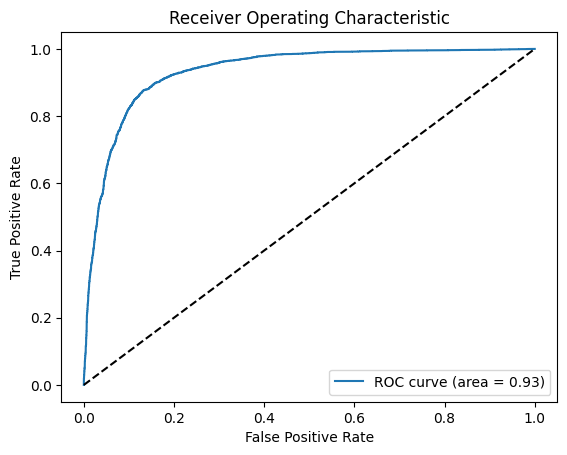

In [17]:
y_pred_prob = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

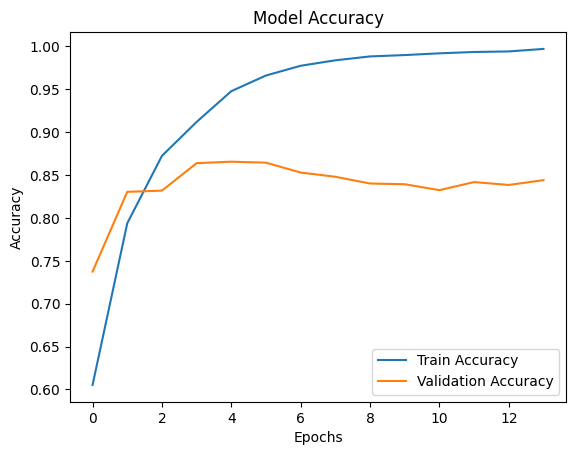

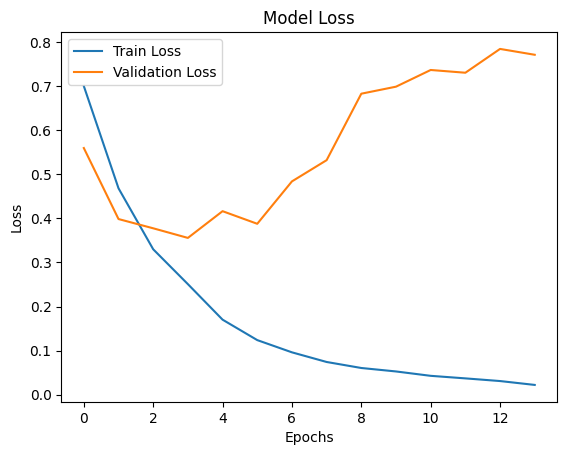

In [18]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Prediksi data baru
new_text = "today i want to talk about something very important which is climate change you know this issue affects all of us and it is crucial that we understand how our actions can impact the planet so let us start by considering small steps we can take in our daily lives things like using public transport reducing plastic waste and saving electricity can go a long way it is not about making drastic changes overnight but about building sustainable habits over time you know every small step counts and together we can make a difference so please think about the choices you make every day and how they can help protect our planet for future generations thank you"
# new_text  = "i ve been at mit for uh 44 years i went to ted i there s only one other person here i think who did that all the other teds and i went to them all under ricky s regime i talked about what the media lab was doing which today has almost 500 people in it and if you read the press last week um it uh actually said i quit the media lab i didn t quit the media lab i stepped down as chairman which was a kind uh of ridiculous title but someone else has taken it on and one of the things you can do as a professor is you stay on as a professor and i will now do for the rest of my life the one laptop per child which i ve sort of been doing for a year and a half anyway so i m going to tell"
new_sequence = tokenizer.texts_to_sequences([new_text])
padded_sequence = pad_sequences(new_sequence, maxlen=max_length, padding='post', truncating='post')

# Prediksi
confidence = model.predict(padded_sequence)[0][0]
confidence_label = int(confidence > 0.5)

print(f"Confidence: {confidence:.2f}")
print(f"Confidence Label: {confidence_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Confidence: 0.79
Confidence Label: 1


In [20]:
# save h5 model
# model.save('./model/text_model.h5')